In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import keras
# from keras.layers import Dense
from keras.models import Sequential
# from tensorflow.keras.utils import to_categorical
# from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import itertools
from keras.layers import LSTM, GRU
# from tensorflow.keras.layers import Conv1D, SeparableConv1D,MaxPooling1D,MaxPooling2D
# from keras.layers import Dropout
# from keras.layers import Bidirectional
from keras.layers import TimeDistributed, Dense, Flatten,ConvLSTM2D,RepeatVector,Dropout, Bidirectional, Dense, LSTM, GRU,Conv1D, SeparableConv1D,MaxPooling1D,MaxPooling2D
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pylab
from pylab import rcParams
import warnings
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import tensorflow as tf
from keras import backend as k


from sklearn.preprocessing import MinMaxScaler
import random
#import data
df = pd.read_csv('https://raw.githubusercontent.com/Truong-Thai-Bao/aqi_airqualitydata_2020/main/aqi_airqualitydata_2020_en.csv')
df

,Date,Country,City,Specie,count,min,max,median,variance
0,17/07/2020,VN,Ho Chi Minh City,temperature,24,26.0,34.0,29.5,59.13
1,21/10/2020,VN,Ho Chi Minh City,temperature,24,26.0,31.0,27.0,26.23
2,07/11/2020,VN,Ho Chi Minh City,temperature,24,25.0,32.5,28.0,69.20
3,22/11/2020,VN,Ho Chi Minh City,temperature,24,24.0,33.5,26.0,102.39
4,10/01/2020,VN,Ho Chi Minh City,temperature,24,23.5,34.0,28.5,125.65
...,...,...,...,...,...,...,...,...,...
16222,26/02/2020,VN,Ha Long,co,28,1.0,9.0,4.0,88.19
16223,27/02/2020,VN,Ha Long,co,34,2.0,9.0,8.0,48.52
16224,29/02/2020,VN,Ha Long,co,22,8.0,9.0,8.0,2.27
16225,24/06/2020,VN,Ha Long,co,48,4.0,8.0,5.0,13.36


#Xem tổng quan dữ liệu

##Kiểu dữ liệu từng cột

In [2]:
print(df.dtypes)

Date         object
Country      object
City         object
Specie       object
count         int64
min         float64
max         float64
median      float64
variance    float64
dtype: object


##Kiểm tra null

In [3]:
df.isnull().sum()

,0
Date,0
Country,0
City,0
Specie,0
count,0
min,0
max,0
median,0
variance,0


##Xem thông tin bộ dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16227 entries, 0 to 16226
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      16227 non-null  object 
 1   Country   16227 non-null  object 
 2   City      16227 non-null  object 
 3   Specie    16227 non-null  object 
 4   count     16227 non-null  int64  
 5   min       16227 non-null  float64
 6   max       16227 non-null  float64
 7   median    16227 non-null  float64
 8   variance  16227 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.1+ MB


##Kiểm tra các unique

In [5]:
#Xem unique các cột không phải là số
cols = ['Country','City','Specie']
for col in cols:
  print(df[col].unique())

['VN']
['Ho Chi Minh City' 'Hue' 'Ha Noi' 'Hai Phong' 'Ha Long']
['temperature' 'humidity' 'wind speed' 'wind-speed' 'wind-gust' 'pm25'
 'dew' 'pressure' 'wind gust' 'co' 'pm10' 'so2' 'no2' 'o3' 'aqi'
 'precipitation']


- Cột 'Country' chỉ có một giá trị là 'VN' nên đây là dữ liệu không có giá trị phân tích. Ta có thể loại bỏ nó ở bước tiền xử lí dữ liệu

- Ta nhận thấy có hai cặp "Specie" có tên khá giống nhau là: (wind speed với wind-speed) và (wind-gust với wind gust) nên có thể dữ liệu sẽ bị trùng lặp. Ta tiến hành thêm các bước kiểm tra để làm rõ.
- Do ta chỉ phân tích trên dữ liệu ở Thành phố Hồ Chí Minh nên sẽ lượt bỏ hết các 'City' còn lại.

#Tiền xử lí dữ liệu 2020

## Bỏ cột 'Country'

In [6]:
# Bỏ các dòng trùng lắp
df = df.drop_duplicates()

In [7]:
#Tạo df chỉ có Ho Chi Minh City
df_hcm = df[df['City']=='Ho Chi Minh City']

In [8]:
#Loại bỏ cột country
df_hcm = df_hcm.drop(columns=['Country'])

In [9]:
#Xem số lượng từng loại
print(df_hcm[df_hcm['Specie']=='wind speed'].shape[0])
print(df_hcm[df_hcm['Specie']=='wind-speed'].shape[0])
print(df_hcm[df_hcm['Specie']=='wind gust'].shape[0])
print(df_hcm[df_hcm['Specie']=='wind-gust'].shape[0])

74
300
2
9


- Đối với loại không có dấu "-" thì chúng luôn nhỏ hơn so với loại có dấu "-" nên rất có thể chúng đã bị trùng lắp. Hay nói cách khác, không có dấu "-" là 'con' của có dấu "-".

In [10]:
#Chuyển Date sang dạng datetime để có thể sort
df_hcm['Date'] = pd.to_datetime(df_hcm['Date'], format='%d/%m/%Y')

##Kiểm tra hai loại wind speed

In [11]:
df_hcm[df_hcm['Specie']=='wind speed'].sort_values(by='Date')

,Date,City,Specie,count,min,max,median,variance
796,2020-01-03,Ho Chi Minh City,wind speed,11,1.0,3.6,2.0,7.52
786,2020-01-04,Ho Chi Minh City,wind speed,24,0.5,3.6,1.5,4.42
793,2020-01-05,Ho Chi Minh City,wind speed,23,0.5,3.3,2.3,6.15
811,2020-01-06,Ho Chi Minh City,wind speed,23,0.5,3.8,2.3,7.07
792,2020-01-07,Ho Chi Minh City,wind speed,24,0.2,3.8,2.0,11.21
...,...,...,...,...,...,...,...,...
756,2020-03-27,Ho Chi Minh City,wind speed,24,1.8,5.1,3.6,9.86
798,2020-03-28,Ho Chi Minh City,wind speed,24,1.5,4.1,3.3,5.81
745,2020-03-29,Ho Chi Minh City,wind speed,23,2.3,5.4,3.6,8.17
806,2020-03-30,Ho Chi Minh City,wind speed,24,1.5,4.3,3.6,5.46


In [12]:
df_hcm[df_hcm['Specie']=='wind-speed'].sort_values(by='Date')

,Date,City,Specie,count,min,max,median,variance
1074,2020-01-03,Ho Chi Minh City,wind-speed,11,1.0,3.6,2.0,7.52
1063,2020-01-04,Ho Chi Minh City,wind-speed,24,0.5,3.6,1.5,4.42
844,2020-01-05,Ho Chi Minh City,wind-speed,23,0.5,3.3,2.3,6.15
946,2020-03-30,Ho Chi Minh City,wind-speed,24,1.5,4.3,3.6,5.46
985,2020-03-31,Ho Chi Minh City,wind-speed,24,1.0,5.1,2.5,17.66
...,...,...,...,...,...,...,...,...
956,2021-01-16,Ho Chi Minh City,wind-speed,24,0.2,4.3,2.5,10.85
1018,2021-01-17,Ho Chi Minh City,wind-speed,24,0.7,5.6,2.5,22.58
970,2021-01-18,Ho Chi Minh City,wind-speed,24,0.5,4.8,2.8,8.92
1019,2021-01-19,Ho Chi Minh City,wind-speed,24,0.5,3.8,1.8,4.89


In [13]:
#Gộp hai loại lại thành một
df_ws = df_hcm[df_hcm['Specie'].isin(['wind speed', 'wind-speed'])].copy()
#Tạo một key duy nhất
df_ws['key'] = df_ws['Date'].astype(str) + '-' + df_ws['City']
#In ra các key xuất hiện hơn 1 lần
print(df_ws['key'].value_counts()[df_ws['key'].value_counts() > 1])

key
2020-03-30-Ho Chi Minh City    2
2020-01-03-Ho Chi Minh City    2
2020-01-05-Ho Chi Minh City    2
2020-03-31-Ho Chi Minh City    2
2020-01-04-Ho Chi Minh City    2
Name: count, dtype: int64


- Như vậy dữ liệu có cùng ngày, cùng thành phố nhưng bị tách thành 2 dòng chỉ vì khác giá trị ở cột 'Specie' ('wind speed và wind-speed). Ta cần phải xử lí.

## Bỏ trùng lắp

In [14]:
#Chuyển về wind speed
df_hcm['Specie'] = df_hcm['Specie'].replace('wind speed', 'wind-speed')

# Bỏ dòng trùng
df_hcm = df_hcm.drop_duplicates(subset=['Date', 'City', 'Specie','count','min','max','median','variance'], keep='first')

## Xử lí hai loại wind gust

- Trong bộ dữ liệu, giá trị wind gust không được sử dụng để phân tích và nó có giá trị NaN chiếm đa số nên ta sẽ loại bỏ nó.

In [15]:
# Bỏ các dòng wind gust
df_hcm = df_hcm[~df_hcm['Specie'].isin(['wind gust', 'wind-gust'])]
#Kiểm tra
print(df_hcm['Specie'].unique())


['temperature' 'humidity' 'wind-speed' 'pm25' 'dew' 'pressure']


## Pivot table về dạng wide

In [16]:
#Chuyển Date về Datetime
df_hcm['Date'] = pd.to_datetime(df_hcm['Date'],dayfirst=True,errors='coerce')

#Pivot sang wide và giữ Date làm index thời gian
df_wide = df_hcm.pivot(index='Date', columns='Specie', values='median').sort_index()

# Nếu có ngày trùng index, bỏ bớt để tránh lỗi
df_wide = df_wide[~df_wide.index.duplicated(keep='first')]
df_wide

Specie,dew,humidity,pm25,pressure,temperature,wind-speed
Date,,,,,,
2019-12-30,NaN,NaN,89.0,NaN,NaN,NaN
2019-12-31,NaN,NaN,82.0,NaN,NaN,NaN
2020-01-01,NaN,NaN,74.0,NaN,NaN,NaN
2020-01-02,NaN,NaN,78.0,NaN,NaN,NaN
2020-01-03,20.0,56.0,85.0,1012.0,29.5,2.0
...,...,...,...,...,...,...
2021-01-16,20.0,73.0,109.0,1010.0,25.0,2.5
2021-01-17,17.0,61.0,82.0,1011.0,25.5,2.5
2021-01-18,14.5,56.0,80.0,1012.0,25.0,2.8


In [17]:
#Bỏ các dòng có Nan
# df_wide = df_wide.dropna()

In [18]:
# Tạo các ngày thiếu nếu có
df_wide = df_wide.asfreq('D')
# Dùng interpolation theo thời gian để điền missing values
num_cols = df_wide.select_dtypes(include='number').columns
df_wide[num_cols] = df_wide[num_cols].interpolate(method='time', limit_direction='both')
df_wide

Specie,dew,humidity,pm25,pressure,temperature,wind-speed
Date,,,,,,
2019-12-30,20.0,56.0,89.0,1012.0,29.5,2.0
2019-12-31,20.0,56.0,82.0,1012.0,29.5,2.0
2020-01-01,20.0,56.0,74.0,1012.0,29.5,2.0
2020-01-02,20.0,56.0,78.0,1012.0,29.5,2.0
2020-01-03,20.0,56.0,85.0,1012.0,29.5,2.0
...,...,...,...,...,...,...
2021-01-16,20.0,73.0,109.0,1010.0,25.0,2.5
2021-01-17,17.0,61.0,82.0,1011.0,25.5,2.5
2021-01-18,14.5,56.0,80.0,1012.0,25.0,2.8


In [19]:
# Chọn thứ tự cột
cols_order = ['temperature', 'dew', 'humidity', 'pressure', 'wind-speed', 'pm25']
df_wide = df_wide[cols_order]
df_wide

Specie,temperature,dew,humidity,pressure,wind-speed,pm25
Date,,,,,,
2019-12-30,29.5,20.0,56.0,1012.0,2.0,89.0
2019-12-31,29.5,20.0,56.0,1012.0,2.0,82.0
2020-01-01,29.5,20.0,56.0,1012.0,2.0,74.0
2020-01-02,29.5,20.0,56.0,1012.0,2.0,78.0
2020-01-03,29.5,20.0,56.0,1012.0,2.0,85.0
...,...,...,...,...,...,...
2021-01-16,25.0,20.0,73.0,1010.0,2.5,109.0
2021-01-17,25.5,17.0,61.0,1011.0,2.5,82.0
2021-01-18,25.0,14.5,56.0,1012.0,2.8,80.0


#Tiền xử lí dữ liệu 2021

In [20]:
df_21 = pd.read_csv('https://github.com/Truong-Thai-Bao/aqi_airqualitydata_2020/blob/861cccf644bc2db02fedbd4a2f1f631aed2d17f7/air_quality_2021_en.csv?raw=1')

In [21]:
df_21 = df_21.drop_duplicates()

In [22]:
#Chỉ lấy dữ liệu ở TPHCM
df_21 = df_21[df_21['Station name']=='Ho Chi Minh City US Consulate, Vietnam (Lãnh sự quán Hoa Kỳ, Hồ Chí Minh)']
df_21.head()

,Station ID,AQI index,Location,Station name,Url,Dominent pollutant,CO,Dew,Humidity,NO2,...,Pressure,PM10,PM2.5,SO2,Temperature,Wind,Data Time S,Data Time Tz,Status,Alert level
0,8767.0,102.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,NaN,83.0,-,...,"1,009.00",NaN,102.00,-,27.0,3.6,2021-01-21 19:00:00,+07:00,#NAME?,#NAME?
23,8767.0,122.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,NaN,56.5,-,...,"1,008.50",NaN,122.00,-,30.5,2.5,2021-01-22 13:00:00,+07:00,#NAME?,#NAME?
46,8767.0,114.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,NaN,49.0,-,...,"1,007.00",NaN,114.00,-,32.0,1.5,2021-01-23 15:00:00,+07:00,#NAME?,#NAME?
69,8767.0,80.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,NaN,74.0,-,...,"1,009.00",NaN,80.00,-,27.0,4.1,2021-01-25 19:00:00,+07:00,#NAME?,#NAME?
92,8767.0,137.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,NaN,62.0,-,...,"1,007.00",NaN,137.00,-,31.0,5.1,2021-01-26 16:00:00,+07:00,#NAME?,#NAME?


In [23]:
# bỏ cột station
df_21 = df_21.drop(columns=['Station ID','AQI index','Location','Station name','Url','Dominent pollutant','CO','NO2','O3','PM10','SO2','Data Time Tz','Status','Alert level'])
df_21

,Dew,Humidity,Pressure,PM2.5,Temperature,Wind,Data Time S
0,NaN,83.0,"1,009.00",102.00,27.0,3.6,2021-01-21 19:00:00
23,NaN,56.5,"1,008.50",122.00,30.5,2.5,2021-01-22 13:00:00
46,NaN,49.0,"1,007.00",114.00,32.0,1.5,2021-01-23 15:00:00
69,NaN,74.0,"1,009.00",80.00,27.0,4.1,2021-01-25 19:00:00
92,NaN,62.0,"1,007.00",137.00,31.0,5.1,2021-01-26 16:00:00
...,...,...,...,...,...,...,...
2507,24.0,66.0,"1,010.00",97.00,31.0,2.8,2021-11-10 10:00:00
2530,24.0,66.0,"1,008.50",65.00,31.0,3.6,2021-11-16 12:00:00
2553,25.0,79.0,"1,009.00",114.00,29.0,1.5,2021-11-20 09:00:00
2576,20.5,69.0,"1,011.00",89.00,26.5,3.0,2021-11-26 09:00:00


In [24]:
#đổi tên cột Dew thành dew
df_21 = df_21.rename(columns={'Dew':'dew','Humidity':'humidity','Pressure':'pressure','Temperature':'temperature','Wind':'wind-speed','PM2.5':'pm25'})

In [25]:
#Giá trị của cột này có dấu , nên không thể convert trực tiếp được
df_21['pressure'] = df_21['pressure'].str.replace(',','').astype(float)
df_21['pm25'] = df_21['pm25'].astype(float)
df_21.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 2599
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          97 non-null     float64
 1   humidity     112 non-null    float64
 2   pressure     112 non-null    float64
 3   pm25         112 non-null    float64
 4   temperature  112 non-null    float64
 5   wind-speed   112 non-null    float64
 6   Data Time S  112 non-null    object 
dtypes: float64(6), object(1)
memory usage: 11.1+ KB


In [26]:
#Chuyển cột thời gian thành datetime
df_21['Data Time S'] = pd.to_datetime(df_21['Data Time S'])
#Xắp xếp theo thời gian
df_21.sort_values(by='Data Time S',inplace=True)
#Làm index
df_21.set_index('Data Time S',inplace=True)
# chỉ áp dụng cho các vị trí NaN của Dew
mask = df_21['dew'].isna()
df_21.loc[mask, 'dew'] = df_21['dew'].rolling(window=3, center=True, min_periods=1).median()[mask]
# còn sót thì ffill/bfill
df_21['dew'] = df_21['dew'].ffill().bfill()
df_21

,dew,humidity,pressure,pm25,temperature,wind-speed
Data Time S,,,,,,
2021-01-21 19:00:00,21.0,83.0,1009.0,102.0,27.0,3.6
2021-01-22 13:00:00,21.0,56.5,1008.5,122.0,30.5,2.5
2021-01-23 15:00:00,21.0,49.0,1007.0,114.0,32.0,1.5
2021-01-25 19:00:00,21.0,74.0,1009.0,80.0,27.0,4.1
2021-01-26 16:00:00,21.0,62.0,1007.0,137.0,31.0,5.1
...,...,...,...,...,...,...
2021-11-10 10:00:00,24.0,66.0,1010.0,97.0,31.0,2.8
2021-11-16 12:00:00,24.0,66.0,1008.5,65.0,31.0,3.6
2021-11-20 09:00:00,25.0,79.0,1009.0,114.0,29.0,1.5


In [27]:
# Chọn thứ tự cột
cols_order = ['temperature', 'dew', 'humidity', 'pressure', 'wind-speed', 'pm25']
df_21 = df_21[cols_order]
df_21

,temperature,dew,humidity,pressure,wind-speed,pm25
Data Time S,,,,,,
2021-01-21 19:00:00,27.0,21.0,83.0,1009.0,3.6,102.0
2021-01-22 13:00:00,30.5,21.0,56.5,1008.5,2.5,122.0
2021-01-23 15:00:00,32.0,21.0,49.0,1007.0,1.5,114.0
2021-01-25 19:00:00,27.0,21.0,74.0,1009.0,4.1,80.0
2021-01-26 16:00:00,31.0,21.0,62.0,1007.0,5.1,137.0
...,...,...,...,...,...,...
2021-11-10 10:00:00,31.0,24.0,66.0,1010.0,2.8,97.0
2021-11-16 12:00:00,31.0,24.0,66.0,1008.5,3.6,65.0
2021-11-20 09:00:00,29.0,25.0,79.0,1009.0,1.5,114.0


#Gôp dữ liệu

In [28]:
#Gộp df_wide và df_21
df_wide = pd.concat([df_wide, df_21])
df_wide

,temperature,dew,humidity,pressure,wind-speed,pm25
2019-12-30 00:00:00,29.5,20.0,56.0,1012.0,2.0,89.0
2019-12-31 00:00:00,29.5,20.0,56.0,1012.0,2.0,82.0
2020-01-01 00:00:00,29.5,20.0,56.0,1012.0,2.0,74.0
2020-01-02 00:00:00,29.5,20.0,56.0,1012.0,2.0,78.0
2020-01-03 00:00:00,29.5,20.0,56.0,1012.0,2.0,85.0
...,...,...,...,...,...,...
2021-11-10 10:00:00,31.0,24.0,66.0,1010.0,2.8,97.0
2021-11-16 12:00:00,31.0,24.0,66.0,1008.5,3.6,65.0
2021-11-20 09:00:00,29.0,25.0,79.0,1009.0,1.5,114.0
2021-11-26 09:00:00,26.5,20.5,69.0,1011.0,3.0,89.0


#Clip tất cả outliers

In [29]:
# def clip_all_outliers(df: pd.DataFrame, cols=None, k=1.5, visualize=False) -> pd.DataFrame:
#     """
#     Clip outlier bằng IQR cho nhiều cột định sẵn trong DataFrame.

#     Tham số:
#     - df: DataFrame có index là Date (df_wide)
#     - cols: danh sách các cột cần xử lý (mặc định là tất cả các cột số)
#     - k: hệ số IQR (1.5 = mặc định)
#     - visualize: vẽ biểu đồ outlier trước khi clip (True/False)

#     Trả về:
#     - df đã được clip
#     """
#     df_clipped = df.copy()
#     if cols is None:
#         cols = df.select_dtypes(include=[np.number]).columns.tolist()

#     for col in cols:
#         series = df[col].dropna()
#         q1 = series.quantile(0.25)
#         q3 = series.quantile(0.75)
#         iqr = q3 - q1
#         lo = q1 - k * iqr
#         hi = q3 + k * iqr
#         num_lo = (series < lo).sum()
#         num_hi = (series > hi).sum()
#         print(f"{col.upper()} → Clip [{lo:.2f}, {hi:.2f}] | Outliers: thấp={num_lo}, cao={num_hi}")

#         if visualize:
#             is_out = (series < lo) | (series > hi)
#             plt.figure(figsize=(10, 4))
#             plt.plot(series.index, series, label='Gốc')
#             plt.scatter(series.index[is_out], series[is_out], color='red', label='Outlier', s=20)
#             plt.axhline(lo, linestyle='--', color='gray')
#             plt.axhline(hi, linestyle='--', color='gray', label='IQR bounds')
#             plt.title(f'Clip IQR: {col}')
#             plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#         # Clip dữ liệu gốc
#         df_clipped[col] = df_clipped[col].clip(lower=lo, upper=hi)

#     print("Đã clip toàn bộ biến.")
#     return df_clipped
# df_wide = clip_all_outliers(df_wide, visualize=False)

#Trực quan hóa các biến giá trị

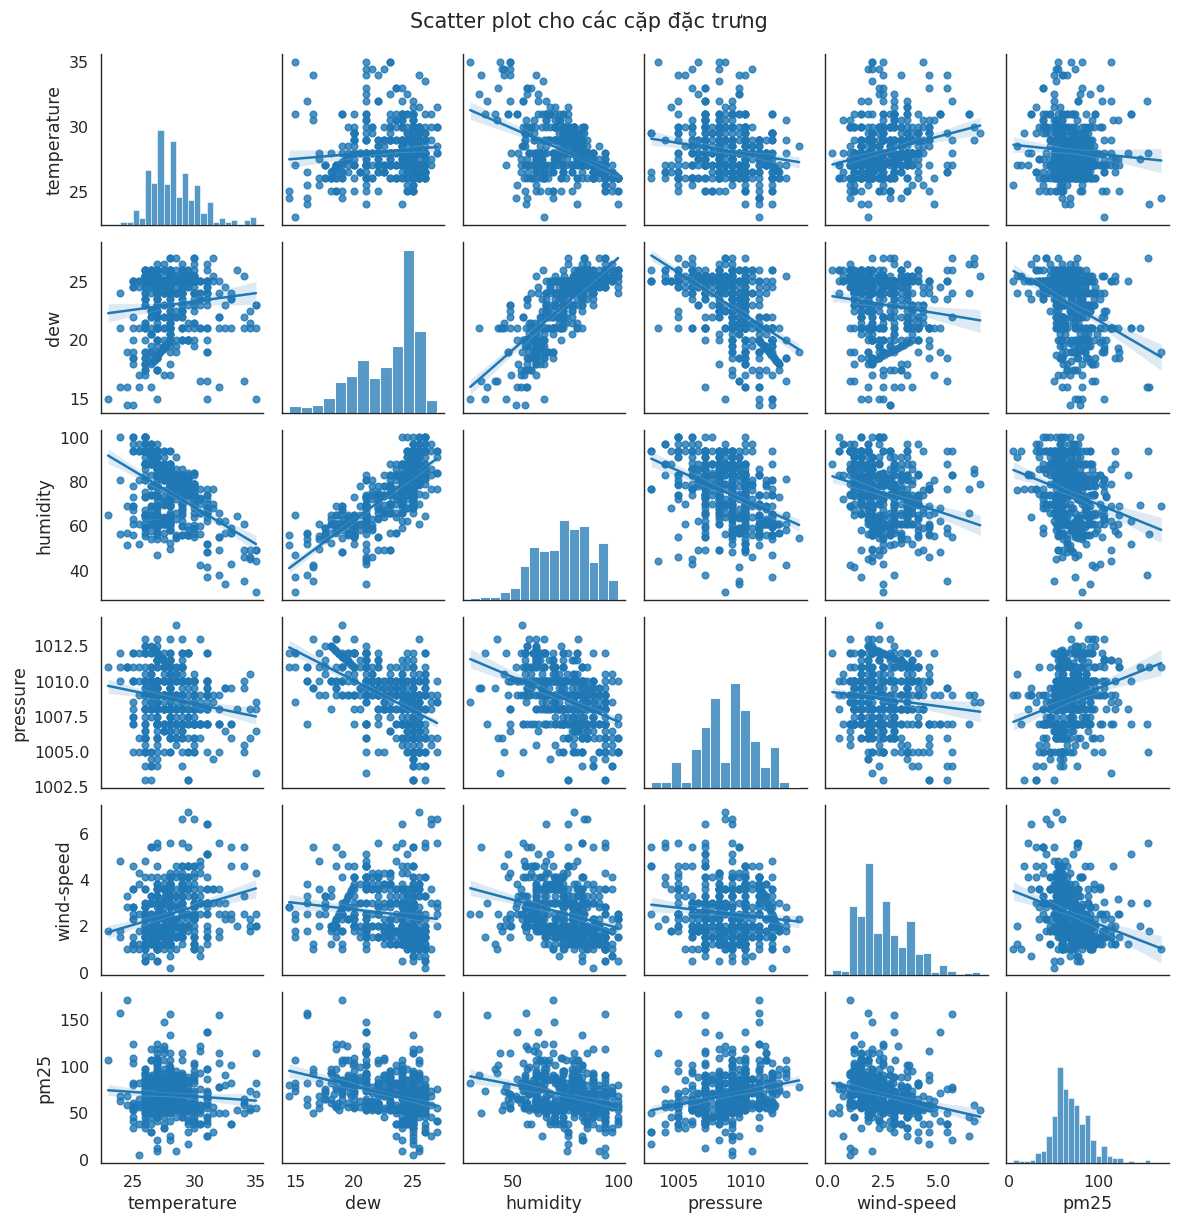

In [30]:
#Vẽ pairplot
sns.pairplot(df_wide,kind='reg',height=2, aspect=1)
plt.suptitle('Scatter plot cho các cặp đặc trưng', y=1.02)
plt.show()


#Các hàm tính toán

In [31]:

seed = 100
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

def parse(x):
        return datetime.strptime(x, '%Y %m %d %H')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        """
        Biến đổi một chuỗi thời gian thành một dataset học có giám sát.

        Tham số:
            data: Dãy quan sát dưới dạng list hoặc mảng NumPy.
            n_in: Số bước trễ dùng làm đầu vào (X).
            n_out: Số bước quan sát dùng làm đầu ra (y).
            dropnan: Kiểu Boolean cho biết có bỏ các hàng chứa giá trị NaN hay không.

        Trả về:
            Pandas DataFrame của chuỗi thời gian đã được biến đổi phục vụ cho học có giám sát.
        """

        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        #Tạo chuỗi input (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # Tạo chuỗi dự đoán (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # Kết hợp lại
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # Bỏ dòng Nan
        if dropnan:
                agg.dropna(inplace=True)
        return agg

######################################################################
def lstm_model(): ## LSTM
    regressor = Sequential()

    regressor.add(LSTM(units = 64, activation='relu', return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
    regressor.add(Dropout(0.1))

    regressor.add(LSTM(units = 64, activation='relu', return_sequences = True))
    regressor.add(Dropout(0.5))

    regressor.add(LSTM(units = 64))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse','mape'])
    return regressor

#########################################
def bilstm_model(): ## Bi-LSTM

    regressor = Sequential()

    regressor.add(Bidirectional(LSTM(units = 64, activation='relu', return_sequences = True), input_shape = (train_X.shape[1], train_X.shape[2])))
    regressor.add(Dropout(0.1))

    regressor.add(Bidirectional(LSTM(units = 64, activation='relu', return_sequences = True)))
    regressor.add(Dropout(0.5))

    regressor.add(Bidirectional(LSTM(units = 64, activation='relu')))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse','mape'])

    return regressor

def cnn_lstm_model(): ## CNN - LSTM
    regressor = Sequential()
    regressor.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    regressor.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    regressor.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
    regressor.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    regressor.add(TimeDistributed(Flatten()))
    regressor.add(LSTM(64, activation='relu',return_sequences=True))
    regressor.add(Dropout(0.1))
    regressor.add(LSTM(64))
    regressor.add(Dropout(0.1))
    regressor.add(Dense(1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mae','mse','mape'])
    return regressor


def cnn_bilstm_model(): ## CNN - BiLSTM
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    return model

def cnn_bilstm_model_ver2(): ## CNN - BiLSTM - v2
    model = Sequential()
    model.add(TimeDistributed(SeparableConv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(SeparableConv1D(filters=32, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(32, activation='relu',return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32)))
    # model.add(Dense(128))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    return model

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(inv_y,inv_yhat):
        # Tính các metrics
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        mse = mean_squared_error(inv_y, inv_yhat)
        mae = mean_absolute_error(inv_y, inv_yhat)
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        return rmse, mse, mae, mape

In [32]:
df_sample = pd.DataFrame(df_wide)
#Preprocessing data
scaler = MinMaxScaler(feature_range=(0, 1))  # Scaling trong khoảng 0-1

# train = dữ liệu trước 2021-01-01
train_vals = df_wide.loc[:'2020-12-31']

# test = dữ liệu từ 2021 trở đi
test_vals  = df_wide.loc['2021-06-01':]

FEATS = ['pm25','temperature','dew','humidity','pressure','wind-speed']  # sửa tên cột cho khớp

# Tính ngưỡng IQR trên TRAIN
bounds = {}
for c in FEATS:
    s = train_vals[c].dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    bounds[c] = (lo, hi)

# Áp ngưỡng cho cả TRAIN & TEST (không tính lại trên test)
for c,(lo,hi) in bounds.items():
    train_vals[c] = train_vals[c].clip(lo, hi)
    test_vals[c]  = test_vals[c].clip(lo, hi)
train_scaled = scaler.fit_transform(train_vals.values.astype('float32'))
test_scaled  = scaler.transform(test_vals.values.astype('float32'))

reframed_train = series_to_supervised(train_scaled, 1, 1)
reframed_train.drop(reframed_train.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed_train.head()

/tmp/ipython-input-1070077168.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_vals[c] = train_vals[c].clip(lo, hi)
/tmp/ipython-input-1070077168.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_vals[c]  = test_vals[c].clip(lo, hi)
/tmp/ipython-input-1070077168.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.75,0.365854,0.169811,0.818176,0.339943,0.722826,0.750000
2,0.75,0.365854,0.169811,0.818176,0.339943,0.646739,0.750000
3,0.75,0.365854,0.169811,0.818176,0.339943,0.559783,0.750000
4,0.75,0.365854,0.169811,0.818176,0.339943,0.603261,0.750000
5,0.75,0.365854,0.169811,0.818176,0.339943,0.679348,0.333333


In [33]:
# Tạo supervised cho test
reframed_test = series_to_supervised(test_scaled, 1, 1)
reframed_test.drop(reframed_test.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed_test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,1.000000,0.756098,0.358491,0.363632,1.000000,0.255435,0.583333
2,0.583333,0.756098,0.547170,0.636360,0.861190,0.494565,1.010417
3,1.010417,0.707317,0.188679,0.363632,1.000000,0.168478,0.833333
4,0.833333,1.048780,0.698113,0.545448,1.000000,0.211957,0.500000
5,0.500000,1.048780,0.886792,0.500000,0.521246,0.211957,0.666667


In [34]:
train = reframed_train.values
test  = reframed_test.values

# Chia thành input và output
train_X, train_y = train[:, :-1], train[:, -1]
test_X,  test_y  = test[:, :-1],  test[:, -1]

# reshape input thành chuỗi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### CNN-Bi-LSTM
n_steps, n_features = train_X.shape[2], train_X.shape[1]
n_seq = 1 #Không chia đoạn vì Bi-lstm
train_X= train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features)) ### CNN - LSTM / CNN - BiLSTM
test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))  ### CNN - LSTM / CNN - BiLSTM

#Define Model
model = cnn_bilstm_model_ver2()
# print("Model CNN-BiLSTM v2 - Use SeparableConv1D")
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(367, 1, 6) (367,) (54, 1, 6) (54,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 5, 32)    │            66 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 5, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 4, 32)    │         1,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 4, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,299 (262.89 KB)

 Trainable params: 67,299 (262.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
model_test = cnn_bilstm_model()
# print("Model CNN-LSTM v1 - Use NormalConv1D")
print(model_test.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_5              │ (None, None, 5, 64)    │           192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, None, 5, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, None, 4, 64)    │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, None, 4, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, None, 256)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 128)      │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,465 (869.00 KB)

 Trainable params: 222,465 (869.00 KB)

 Non-trainable params: 0 (0.00 B)

None








#Huấn luyện mô hình

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.2590 - mae: 0.4537 - mape: 280372.9688 - mse: 0.2590 - val_loss: 0.4378 - val_mae: 0.6013 - val_mape: 89.7173 - val_mse: 0.4378
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2002 - mae: 0.3870 - mape: 2251171.0000 - mse: 0.2002 - val_loss: 0.3086 - val_mae: 0.4870 - val_mape: 71.0974 - val_mse: 0.3086
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1121 - mae: 0.2690 - mape: 6294194.0000 - mse: 0.1121 - val_loss: 0.1116 - val_mae: 0.2793 - val_mape: 59.6058 - val_mse: 0.1116
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0549 - mae: 0.1912 - mape: 14492303.0000 - mse: 0.0549 - val_loss: 0.1126 - val_mae: 0.2806 - val_mape: 59.4176 - val_mse: 0.1126
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0520 - mae: 0.1820 - mape: 13003711.0000 - mse: 0.0520 - val_loss: 0.1270 - val_mae: 0.2992 - val_mape: 58.7728 - val_mse: 0.1270
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1

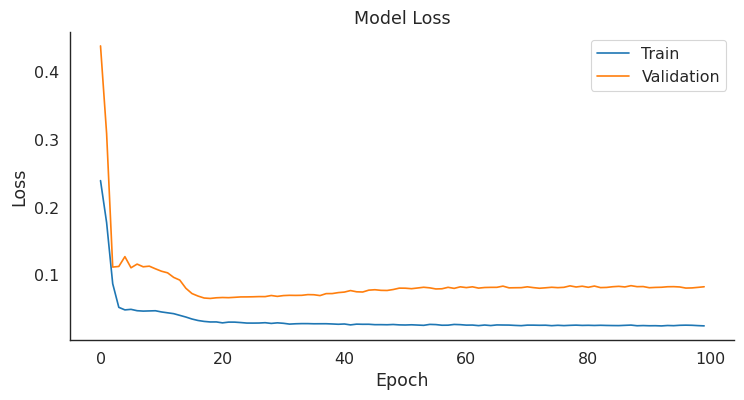

In [36]:
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data=(test_X, test_y), verbose=1)


#### Vẽ plot epochs
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.show()

#Dự đoán

In [37]:
## Dự đoán
yhat = model.predict(test_X)
# print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 6))
# Đảo ngược scaling giá trị dự đoán
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
#print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Đạo ngược scaling giá trị thực tế
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse, mse, mae, mape = calculate_metrics(inv_y, inv_yhat)

print("Test MSE: %.3f" %mse)
print('Test RMSE: %.3f' % rmse)
print("Test MAE: %.3f" % mae)
print("Test MAPE: %.3f" % mape)

print(test_y.shape)
print(yhat.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Test MSE: 2.974
Test RMSE: 1.725
Test MAE: 1.470
Test MAPE: 5.088
(54, 1)
(54, 1)


#Trực quan hóa kết quả

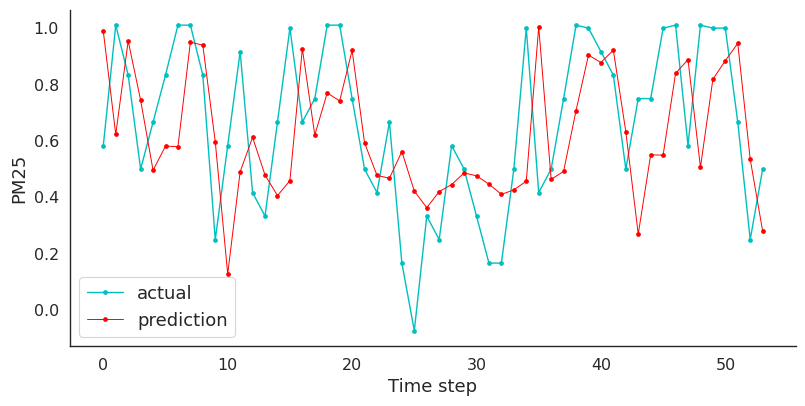

In [38]:
shape = test_y.shape[0]
aa=[x for x in range(shape)] ## test shape
plt.figure(figsize=(8,4))
pylab.plot(aa, test_y[:,0][:shape],'c',linewidth=1, marker='.', label="actual")
pylab.plot(aa, yhat[:,0][:shape], 'r', linewidth= 0.7, marker='.', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.title('model prediction', fontsize=13)
plt.ylabel('PM25', size=13)
plt.xlabel('Time step', size=13)
plt.legend(fontsize=13)
plt.show()
# plt.savefig('LSTM - predict.png')